c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

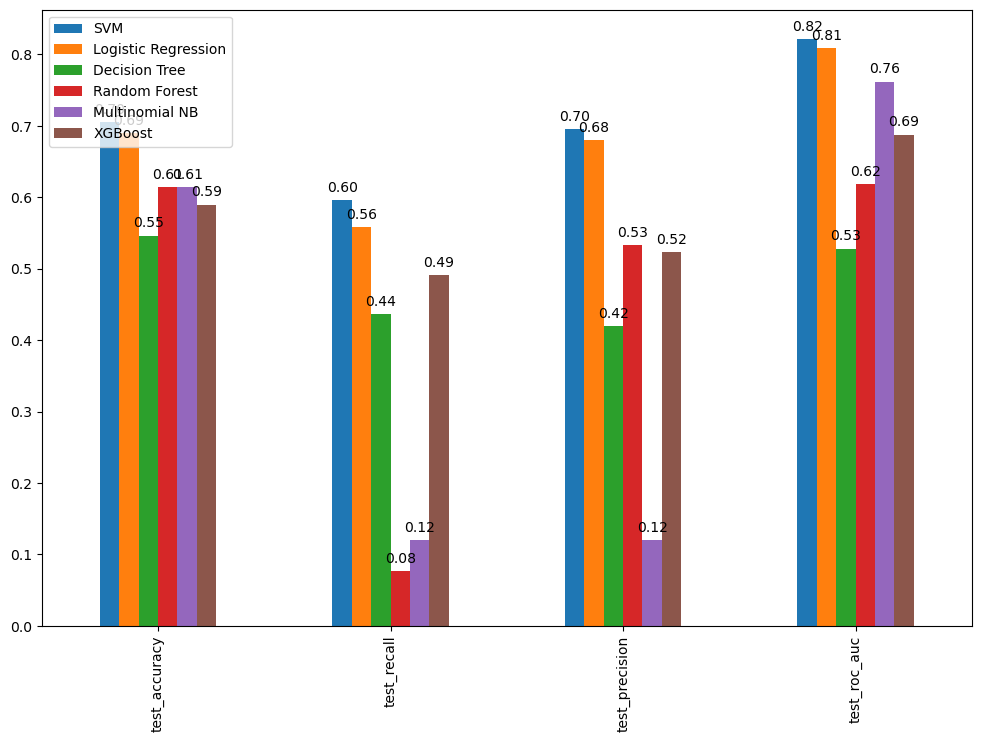

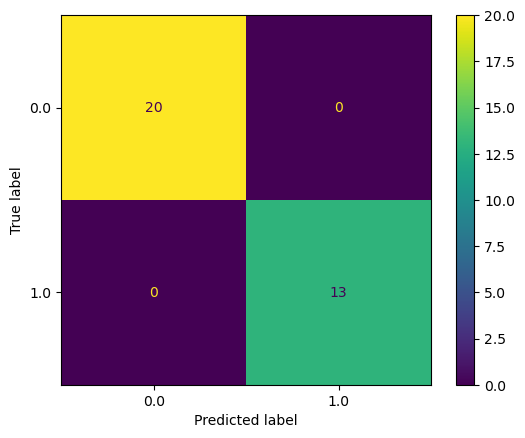

c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


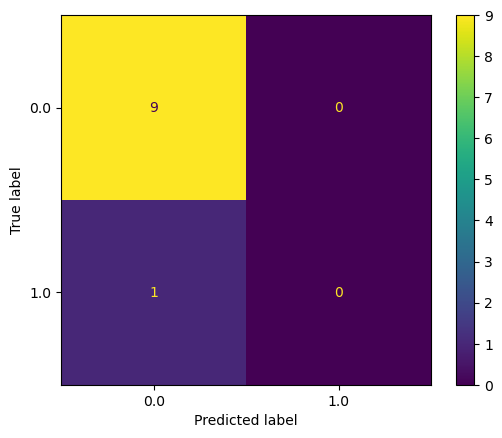

c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\anaconda3\envs\j_scraper\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

ROC AUC: 0.11111111111111116

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10


Confusion Matrix:
[[9 0]
 [1 0]]


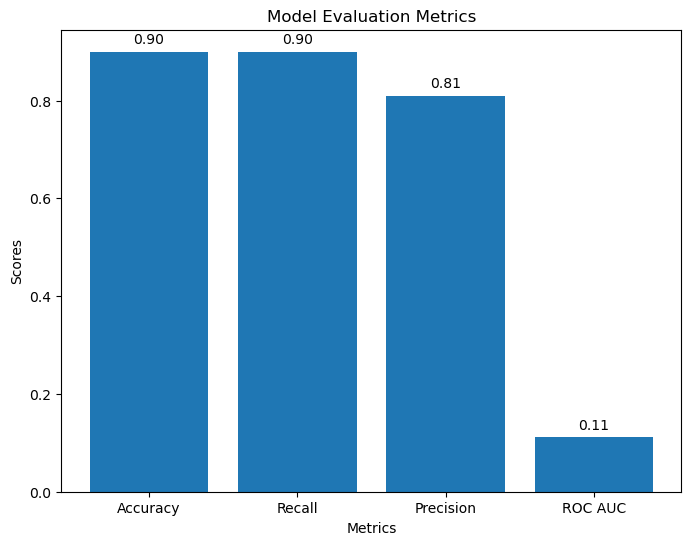

predictions
0.0    117
1.0     33
Name: count, dtype: int64


In [5]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
# Ensure NLTK dependencies are downloaded
# nltk.download('stopwords')
# nltk.download('wordnet')

def preprocess_text(text, stop_words):
    text = re.sub(r'<.*?>', '', text)
    text = text.replace('\n', ' ')
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words]
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def create_corpus(df, stop_words):
    return df.apply(lambda x: preprocess_text(x, stop_words))

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath).drop(['Unnamed: 0'], axis=1).drop_duplicates(subset=['titles', 'companies', 'locations', 'desc'])    
    df['desc'] = df['desc2'].map(lambda x: x.replace("\n", " "))
    df['titles'] = df['titles'].map(lambda x: x.replace("\n", " "))
    df = df.drop(['locations', 'links', 'rating', 'entry (0,1,2) 0 is senior, 2 entry', 'time_delta', 'Scrape Date', 'desc2'], axis=1)
    df = df.reset_index(drop=True)
    df['word_count'] = df['desc'].apply(lambda x: len(str(x).split(" ")))
    
    return df

def create_bag_of_words(corpus, titles_corpus, stop_words):
    cv_desc = CountVectorizer(max_df=0.8, stop_words=list(stop_words), max_features=100000, ngram_range=(1, 2))
    X_desc = cv_desc.fit_transform(corpus)
    
    cv_titles = CountVectorizer(max_df=0.8, stop_words=list(stop_words), max_features=100000, ngram_range=(1, 2))
    X_title = cv_titles.fit_transform(titles_corpus)
    
    tfidf_transformer_desc = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer_title = TfidfTransformer(smooth_idf=True, use_idf=True)
    
    tfidf_transformer_desc.fit(X_desc)
    tfidf_transformer_title.fit(X_title)
    
    tfidf_desc = tfidf_transformer_desc.transform(X_desc)
    tfidf_title = tfidf_transformer_title.transform(X_title)
    
    tfidf = hstack((tfidf_desc, tfidf_title))
    
    return tfidf, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title

def grid_search_models(X_train, y_train):
    param_grid_svm = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'degree': [3, 4, 5],
        'coef0': [0.0, 0.1, 0.5, 1.0]
    }
    
    param_grid_log = {
        'C': [0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l2', 'none'],
        'max_iter': [100, 200, 300]
    }
    
    svm_model = svm.SVC(random_state=0)
    log_model = LogisticRegression(random_state=0)
    
    grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', verbose=3)
    grid_log = GridSearchCV(log_model, param_grid_log, cv=5, scoring='accuracy', verbose=3)
    
    grid_svm.fit(X_train, y_train)
    grid_log.fit(X_train, y_train)
    
    print("Best parameters for SVM:", grid_svm.best_params_)
    print("Best parameters for Logistic Regression:", grid_log.best_params_)
    
    return {
        'SVM': grid_svm.best_estimator_,
        'Logistic Regression': grid_log.best_estimator_
    }

def evaluate_models(tfidf_labelled, targets):
    X_train, X_test, y_train, y_test = train_test_split(tfidf_labelled, targets, random_state=0)
    
    # best_estimators = grid_search_models(X_train, y_train)
        # Given best estimators
    best_estimators = {
        'SVM': svm.SVC(C=10, degree=4, kernel='poly'),
        'Logistic Regression': LogisticRegression(C=1, solver='newton-cg')
    }
    
    models = {
        'SVM': best_estimators['SVM'],
        'Logistic Regression': best_estimators['Logistic Regression'],
        'Decision Tree': DecisionTreeClassifier(random_state=0),
        'Random Forest': RandomForestClassifier(random_state=0),
        'Multinomial NB': MultinomialNB(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0)
    }
    
    scoring = ['accuracy', 'recall', 'precision', 'roc_auc']
    metrics_list = ['test_accuracy', 'test_recall', 'test_precision', 'test_roc_auc']
    
    cv_scores = {metric: [] for metric in metrics_list}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        cv_results = cross_validate(model, tfidf_labelled, targets, cv=5, scoring=scoring, return_train_score=True)
        for metric in metrics_list:
            cv_scores[metric].append(cv_results[metric].mean())
    
    df_metrics = pd.DataFrame(cv_scores).T
    df_metrics.columns = models.keys()
    ax = df_metrics.plot(kind="bar", figsize=(12, 8))
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
    plt.legend(models.keys())
    plt.show()
    
    svm_model = best_estimators['SVM']
    svm_model.fit(tfidf_labelled, targets)
    
    y_pred = svm_model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
    return svm_model

def preprocess_and_vectorize_data(df, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title, stop_words):
    corpus = create_corpus(df['desc'], stop_words)
    titles_corpus = create_corpus(df['titles'], stop_words)
    X_desc = cv_desc.transform(corpus)
    X_title = cv_titles.transform(titles_corpus)
    tfidf_desc = tfidf_transformer_desc.transform(X_desc)
    tfidf_title = tfidf_transformer_title.transform(X_title)
    return hstack((tfidf_desc, tfidf_title))

def plot_metrics(metrics):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics.keys(), metrics.values())
    for i, v in enumerate(metrics.values()):
        ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Model Evaluation Metrics')
    plt.show()

def fine_tune_and_evaluate_model(jobs_full_path, stop_words, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title):
    df_new = load_and_preprocess_new_data(jobs_full_path, stop_words)
    job_df_full = pd.read_csv(jobs_full_path)
    df_new['label'] = job_df_full['true_labels']

    tfidf_new = preprocess_and_vectorize_data(df_new, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title, stop_words)

    labels = df_new['label']
    label_array_new = np.array(labels)
    tfidf_labelled_new = tfidf_new.tocsr()[label_array_new >= 0, :]
    targets_new = df_new[df_new['label'] >= 0]['label'].values

    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(tfidf_labelled_new, targets_new, test_size=0.2)

    pretrained_svm_model = joblib.load('best_svm_model.pkl')
    pretrained_svm_model.fit(X_train_new, y_train_new)

    y_pred_new = pretrained_svm_model.predict(X_val_new)

    accuracy = accuracy_score(y_val_new, y_pred_new)
    recall = recall_score(y_val_new, y_pred_new, average='weighted')
    precision = precision_score(y_val_new, y_pred_new, average='weighted')

    metrics = {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision
    }

    ConfusionMatrixDisplay.from_predictions(y_val_new, y_pred_new)
    plt.show()

    if len(np.unique(y_val_new)) > 1:
        roc_auc = roc_auc_score(y_val_new, pretrained_svm_model.decision_function(X_val_new), multi_class='ovo', average='weighted')
        metrics['ROC AUC'] = roc_auc
        print("ROC AUC:", roc_auc)
    else:
        print("ROC AUC score cannot be calculated because there is only one class in the validation set.")

    print("\nClassification Report:")
    print(classification_report(y_val_new, y_pred_new))

    plot_metrics(metrics)

def load_and_predict_new_jobs(job_board_url, stop_words, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title, pretrained_svm_model):
    driver = webdriver.Chrome(service=Service(r"C:\Users\Administrator\Documents\Personal\chromedriver-win64\chromedriver-win64\chromedriver.exe"))
    driver.get(job_board_url)
    time.sleep(3)

    for _ in range(20):
        driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
        time.sleep(1)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    job_cards = soup.find_all('div', class_='GoEOPd')
    if len(job_cards) == 0:
        job_cards = soup.find_all('li', class_='iFjolb gws-plugins-horizon-jobs__li-ed')

    all_descriptions = soup.find_all('span', class_='HBvzbc')
    jobs = []
    for index, card in enumerate(job_cards):
        title = card.find('div', class_='BjJfJf PUpOsf').text if card.find('div', class_='BjJfJf PUpOsf') else 'N/A'
        company = card.find('div', class_='vNEEBe').text if card.find('div', class_='vNEEBe') else 'N/A'
        location = card.find('div', class_='Qk80Jf').text if card.find('div', class_='Qk80Jf') else 'N/A'
        description = all_descriptions[index] if index < len(all_descriptions) else 'N/A'
        if type(description) != str:
            description = description.get_text(separator=' ', strip=True)
        jobs.append({'titles': title, 'companies': company, 'location': location, 'desc': description})

    driver.quit()

    jobs_df = pd.DataFrame(jobs)
    jobs_df['company_in_description'] = jobs_df.apply(lambda row: row['companies'] in row['desc'], axis=1)

    new_desc_corpus = preprocess_new_data(jobs_df['desc'], stop_words)
    new_title_corpus = preprocess_new_data(jobs_df['titles'], stop_words)

    X_new_desc = cv_desc.transform(new_desc_corpus)
    X_new_title = cv_titles.transform(new_title_corpus)

    tfidf_new_desc = tfidf_transformer_desc.transform(X_new_desc)
    tfidf_new_title = tfidf_transformer_title.transform(X_new_title)

    X_new = hstack((tfidf_new_desc, tfidf_new_title))

    new_predictions = pretrained_svm_model.predict(X_new)
    jobs_df['predictions'] = new_predictions

    print(jobs_df['predictions'].value_counts())

    return jobs_df



def load_and_preprocess_new_data(filepath, stop_words):
    """
    Loads and preprocesses the new dataset.
    
    Args:
    filepath (str): The path to the CSV file containing the new dataset.
    stop_words (set): A set of stopwords to remove from the text.
    
    Returns:
    pd.DataFrame: The preprocessed DataFrame.
    """
    df_new = pd.read_csv(filepath).drop(['Unnamed: 0'], axis=1)
    df_new = df_new.drop_duplicates(subset=['titles', 'companies', 'desc'])
    if 'desc2' in df_new.columns:
        df_new['desc'] = df_new['desc2'].map(lambda x: x.replace("\n", " "))
    else:
        df_new['desc'] = df_new['desc'].map(lambda x: x.replace("\n", " "))
    df_new['titles'] = df_new['titles'].map(lambda x: x.replace("\n", " "))
    if 'desc2' in df_new.columns:
        df_new = df_new.drop(['locations', 'links', 'rating', 'entry (0,1,2) 0 is senior, 2 entry', 'time_delta', 'Scrape Date', 'desc2'], axis=1)
    else:
        df_new = df_new.drop(['company_in_description', 'predictions', 'true_labels', 'true_labels_5'], axis=1)

    df_new = df_new.reset_index().drop(['index'], axis=1)
    df_new['word_count'] = df_new['desc'].apply(lambda x: len(str(x).split(" ")))
    
    return df_new


def preprocess_new_data(new_data, stop_words):
    """
    Preprocesses the new job data in the same way as the training data.
    
    Args:
    new_data (pd.Series): A pandas series containing the new job descriptions.
    stop_words (set): A set of stopwords to remove from the text.
    
    Returns:
    list: A list of preprocessed text data.
    """
    return new_data.apply(lambda x: preprocess_text(x, stop_words))

# Main script
data_PATH = r'C:\Users\Administrator\Documents\Personal\data\df_desc_corrected.csv'
df = load_and_preprocess_data(data_PATH)

stop_words = set(stopwords.words("english")).union(['said', 'would', 'could', "also", "new"])

corpus = create_corpus(df['desc'], stop_words)
titles_corpus = create_corpus(df['titles'], stop_words)

tfidf, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title = create_bag_of_words(corpus, titles_corpus, stop_words)

label_array = np.array(df.label)
tfidf_labelled = tfidf.tocsr()[label_array >= 0, :]
targets = df[df['label'] >= 0]['label'].values

best_svm_model = evaluate_models(tfidf_labelled, targets)

joblib.dump(best_svm_model, 'best_svm_model.pkl')

jobs_full_path = 'job_df_full.csv'
fine_tune_and_evaluate_model(jobs_full_path, stop_words, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title)

job_board_url = r"https://www.google.com/search?client=firefox-b-1-d&sca_esv=1ebb0e033accb772&q=data+scientist+san+francisco&prmd=invmsb&sa=X&biw=1760&bih=875&dpr=1.09&jbr=sep:0&ibp=htl;jobs&ved=2ahUKEwj49KjYwJqGAxWHQzABHdcfACMQudcGKAF6BAgiECk#fpstate=tldetail&htivrt=jobs&htidocid=R2A6Q-IkYWZ1jy46AAAAAA%3D%3D"
pretrained_svm_model = joblib.load('best_svm_model.pkl')
output = load_and_predict_new_jobs(job_board_url, stop_words, cv_desc, cv_titles, tfidf_transformer_desc, tfidf_transformer_title, pretrained_svm_model)
